# CASA 0002 - Urban Simulation
## Final Asssessment - London Underground Resilience
Gavin Rolls
9 February 2024

### Environment Setup

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import networkx as nx
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from shapely import wkt
from scipy.spatial import distance
import csv
import heapq

# Part I - Topological Network Resilience
## Data Loading & Cleaning - Taken from Wk. 10 Practical

In [2]:
#Data Load
#Get File from Wk.10 - Only difference is Multigraph was created from cleaned edges 
#so multiple lines could be represented across station pairs - this code is commented below

G = nx.read_graphml('Data/london_multi.graph')
G_single = nx.read_graphml('Data/london.graph')

# Remove duplicates
unique_edges = set()  # Set to store unique edges
edges_to_remove = []  # List to store edges to remove
for u, v, key, attrs in G.edges(data=True, keys=True):
    # Get the line name attribute
    line_name = attrs.get('line_name')
    edge_data = (u, v, line_name)
    if edge_data in unique_edges:
        edges_to_remove.append((u, v, key))
    else:
        unique_edges.add(edge_data)

# Remove duplicate edges from the graph
for u, v, key in edges_to_remove:
    G.remove_edge(u, v, key)

# Check if any isolated nodes are left and remove them
G.remove_nodes_from(list(nx.isolates(G)))

#Get London_OD_AM_Peak
london_OD_AMpeak = pd.read_csv("./Data/london_flows.csv")

# Save the modified graph
#nx.write_graphml(G, 'Data/london_multi_no_duplicates.graphml')

{'Hammersmith & City', 'Piccadilly', 'Victoria', 'Bakerloo', 'Central', 'London Overground', 'Waterloo & City', 'Metropolitan', 'DLR', 'Northern', 'Circle', 'District', 'Jubilee', 'TfL Rail'}


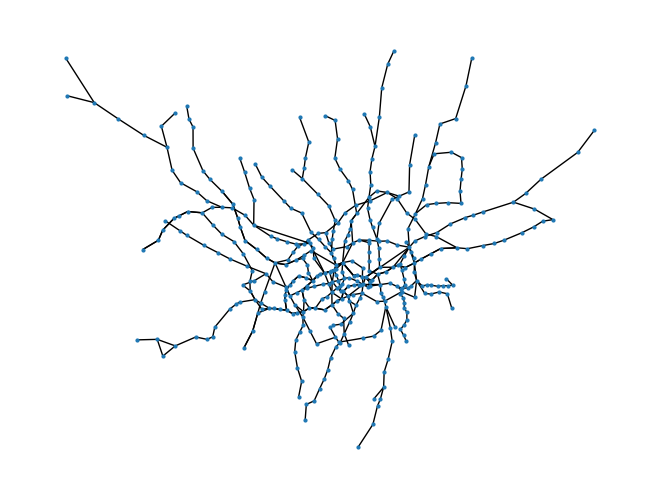

In [3]:
#Data cleaning - Code borrowed from Practical Week 10
#stations = pd.read_csv("./Data/stations.csv")

stations =  pd.read_csv("./Data/stations.csv")

stations['geometry'] = stations['geometry'].apply(wkt.loads)

#Assign positions
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [4]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

In [5]:
#Merge with OD Data
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])

name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]

In [6]:
##A REMINDER OF WHAT'S STORED HERE

edges_with_attributes = []

# Iterate over edges
for u, v, attrs in G.edges(data=True):
    edges_with_attributes.append((u, v, attrs))

print(edges_with_attributes)
london_OD_AMpeak.head()

def export_to_csv(data, filename):
    """
    Export data to a CSV file.
    
    Args:
        data (list of tuples): Data to be exported.
        filename (str): Name of the CSV file.
    """
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in data:
            writer.writerow(row)
        
#Exports edgelist to check further formatting

#export_to_csv(edges_with_attributes, 'out_dupremoved.csv')

london_OD_AMpeak.head()

[('Wembley Park', 'Kingsbury', {'length': 2916.771558048904, 'line_name': 'Jubilee'}), ('Wembley Park', 'Neasden', {'length': 2353.165938195632, 'line_name': 'Jubilee'}), ('Wembley Park', 'Preston Road', {'length': 1419.735165763733, 'line_name': 'Metropolitan'}), ('Wembley Park', 'Finchley Road', {'length': 7266.373927496212, 'line_name': 'Metropolitan'}), ('Kingsbury', 'Queensbury', {'length': 1245.9952343630473, 'line_name': 'Jubilee'}), ('Queensbury', 'Canons Park', {'length': 1693.3073431996115, 'line_name': 'Jubilee'}), ('Canons Park', 'Stanmore', {'length': 1419.6694762450543, 'line_name': 'Jubilee'}), ('Stratford', 'West Ham', {'length': 1673.5095151319483, 'line_name': 'Jubilee'}), ('Stratford', 'Mile End', {'length': 2805.0013918572727, 'line_name': 'Central'}), ('Stratford', 'Leyton', {'length': 2131.34292592479, 'line_name': 'Central'}), ('Stratford', 'Liverpool Street', {'length': 6698.461270479768, 'line_name': 'TfL Rail'}), ('Stratford', 'Maryland', {'length': 951.304720

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [7]:
#Dijkstras Function which incorporates transfer penalties
#ChatGPT helped with this one because I forgot a lot about how Dijkstra's works


def dijkstra_transfer(G, source, target, penalty):
    """
    Compute shortest path in a MultiGraph with distance penalties for switching between edges of different line_names.
    
    Args:
        G (nx.MultiGraph): The MultiGraph.
        source: Source node.
        target: Target node.
        penalty (float): Distance add (metres) for each transfer (2.08km computed).
        
    Returns:
        path_edges (list): Shortest path edges with line_name.
    """

    # Initialise variables
    visited = set()
    distances = {node: float('inf') for node in G.nodes()}
    distances[source] = 0
    previous = {}

    # Dijkstra's algorithm with penalty
    pq = [(0, source, None)]  # Priority queue of (distance, node, line_name)
    starting_lines = []  # Store the line name of the starting edge
    while pq:
        dist, current_node, current_line = heapq.heappop(pq)
        if current_node in visited:
            continue
        visited.add(current_node)
        if current_node == target:
            break

        for neighbor, edge_data in G[current_node].items():
            for edge_key, edge_attr in edge_data.items():
                # Get the color of the current edge
                current_color = edge_attr.get('line_name', None)
                
                # Set the line name of the starting edge
                if current_node == source:
                    starting_lines.append(current_color)
                
                # Compute the distance with penalty for switching colors
                alt_distance = dist + edge_attr.get('length', 1)
                if current_line is not None and current_line != current_color:
                    alt_distance += penalty
                if alt_distance < distances[neighbor]:
                    distances[neighbor] = alt_distance
                    heapq.heappush(pq, (alt_distance, neighbor, current_color))
                    previous[neighbor] = (current_node, current_color)

    # Reconstruct shortest path for the source to target
    path_edges = []
    current_node = target

    while current_node != source:
        if current_node not in previous:
            print("Error: No path from source to target")
            print(source)
            print(target)
            return [], -1  # Return an empty path and -1 for transfers if no path is found

        previous_node, line_name = previous[current_node]
        path_edges.insert(0, (previous_node, current_node, line_name))
        current_node = previous_node

    # Add line_name for the first path edge
    try:
        if path_edges[1][2] in starting_lines:
            path_edges[0] = (path_edges[0][0], path_edges[0][1], path_edges[1][2])
        else:
            path_edges[0] = (path_edges[0][0], path_edges[0][1], starting_lines[-1])
    except:
        pass
        
    return path_edges



In [10]:
#Add Flow Data

#create a dictionary to store flows for all edges
flows = {(u, v, line_name): 0 for u, v in G.edges() if 'line_name' in G[u][v]}

#calculate shortest paths for all flows and add data to dict
#Save flows
flows_for_later = london_OD_AMpeak

for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    if source == target:
        continue
    
    #get shortest path (edges computed)
    #2008 distance penalty derived from average speed of train and average transfer time
    path = dijkstra_transfer(G, source, target, 10000)
    
    #Get transfer count
    line_changes = 0
    previous_line = None
    
    for origin, destination, line_name in path:
        if previous_line is not None and line_name != previous_line:
            line_changes += 1
        previous_line = line_name
    
    #Add transfer count to station flow table
    london_OD_AMpeak.at[i, 'transfer_count'] = line_changes
    
    #Add path to station flow table
    london_OD_AMpeak.at[i, 'path'] = path

    for u, v, line_name in path:
        if (u, v) in G.edges():
            key = (u, v, line_name)
        else:
            key = (v, u, line_name)
        # Increment flow value
        flows[key] = flows.get(key, 0) + row.flows

In [11]:
print(flows)

london_OD_AMpeak.head(100)

#london_OD_AMpeak.to_csv('pathsplusplus.csv')

{('Abbey Road', 'West Ham', 'DLR'): 1195, ('West Ham', 'Star Lane', 'DLR'): 1359, ('Star Lane', 'Canning Town', 'DLR'): 767, ('Canning Town', 'East India', 'DLR'): 20883, ('East India', 'Blackwall', 'DLR'): 21160, ('Blackwall', 'Poplar', 'DLR'): 21723, ('Poplar', 'Westferry', 'DLR'): 30981, ('Westferry', 'Limehouse', 'DLR'): 45649, ('Limehouse', 'Shadwell', 'DLR'): 46467, ('Shadwell', 'Bank and Monument', 'DLR'): 40640, ('Canning Town', 'Royal Victoria', 'DLR'): 4652, ('Royal Victoria', 'Custom House', 'DLR'): 4019, ('Custom House', 'Prince Regent', 'DLR'): 3243, ('Prince Regent', 'Royal Albert', 'DLR'): 2561, ('Royal Albert', 'Beckton Park', 'DLR'): 1920, ('Beckton Park', 'Cyprus', 'DLR'): 1837, ('Cyprus', 'Gallions Reach', 'DLR'): 993, ('Gallions Reach', 'Beckton', 'DLR'): 442, ('Poplar', 'West India Quay', 'DLR'): 15095, ('West India Quay', 'Canary Wharf', 'DLR'): 32693, ('Canary Wharf', 'Heron Quays', 'DLR'): 10347, ('Heron Quays', 'South Quay', 'DLR'): 8540, ('South Quay', 'Crossh

,station_origin,station_destination,flows,population,jobs,distance,transfer_count,path
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.0,"[(Abbey Road, West Ham, DLR), (West Ham, Star ..."
1,Abbey Road,Beckton,1,599,442,8510.121774,0.0,"[(Abbey Road, West Ham, DLR), (West Ham, Star ..."
2,Abbey Road,Blackwall,3,599,665,3775.448872,0.0,"[(Abbey Road, West Ham, DLR), (West Ham, Star ..."
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,0.0,"[(Abbey Road, West Ham, DLR), (West Ham, Star ..."
4,Abbey Road,Canning Town,37,599,15428,2228.923167,0.0,"[(Abbey Road, West Ham, DLR), (West Ham, Star ..."
...,...,...,...,...,...,...,...,...
95,Acton Town,Alperton,35,3745,741,4973.087944,0.0,"[(Acton Town, Ealing Common, Piccadilly), (Eal..."
96,Acton Town,Amersham,0,3745,256,37455.592190,1.0,"[(Acton Town, Ealing Common, Piccadilly), (Eal..."
97,Acton Town,Angel,11,3745,8103,15763.972660,1.0,"[(Acton Town, Turnham Green, Piccadilly), (Tur..."
98,Acton Town,Archway,1,3745,2193,18217.625690,2.0,"[(Acton Town, Turnham Green, Piccadilly), (Tur..."


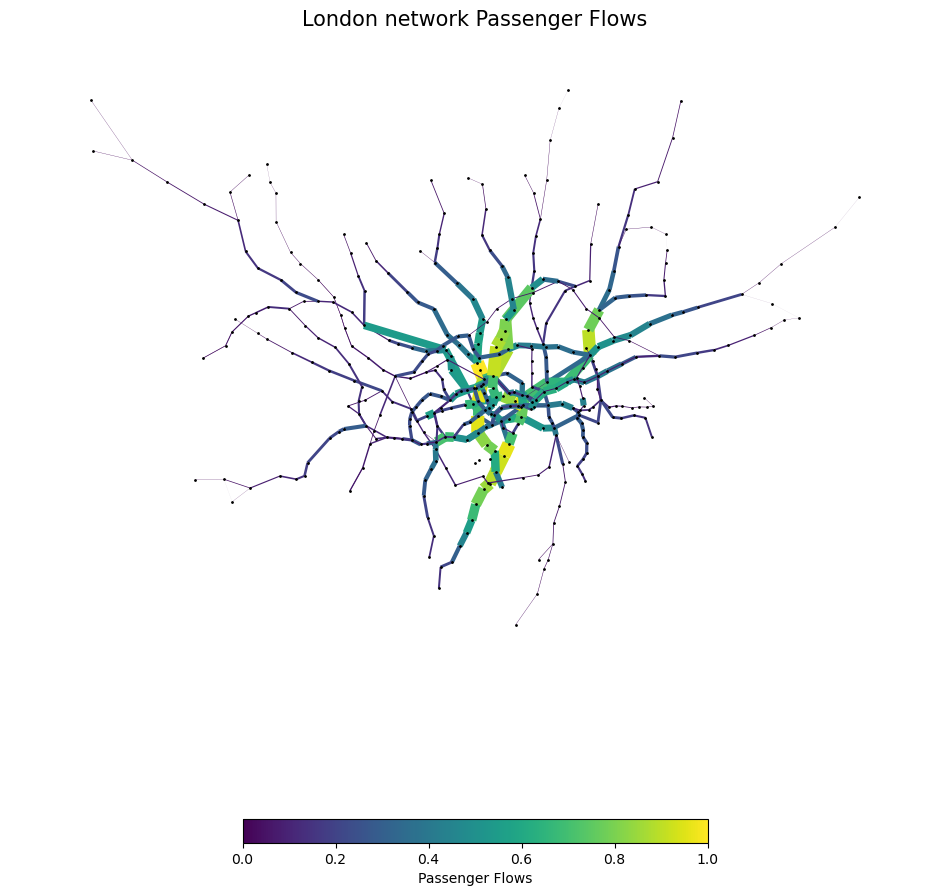

In [12]:
# Iterate over flows and update graph edges with 'flows' attribute
for (origin, destination, line_name), flow_count in flows.items():
    if G.has_edge(origin, destination):
        # Get all edges between origin and destination
        edges = G.edges(origin, destination, keys=True)
        
        # Check each edge for the matching line_name attribute
        for u, v, keys, data in edges:
            data = G.get_edge_data(u, v, key=keys)
            if data and 'line_name' in data and data['line_name'] == line_name:
                # Update the 'flows' attribute for the edge with matching line_name
                if u == origin and v == destination:
                    G[u][v][keys]['flows'] = flow_count
                    
#Write to CSV                 
"""     
csv_filename = "edgelist.csv"

# Open the CSV file in write mode
with open(csv_filename, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header row
    csv_writer.writerow(['Source', 'Target', 'Line Name', 'Flows'])  # Adjust the column headers as needed

    # Iterate over the edges and write them to the CSV file
    for u, v, data in G.edges(data=True):
        source = u
        target = v
        line_name = data.get('line_name', '')  # Get line_name attribute, default to empty string if not present
        flows = data.get('flows', 0)  # Get flows attribute, default to 0 if not present
        csv_writer.writerow([source, target, line_name, flows])
"""             
                    
flows_values = flows.values()

# Plot calculated flows
flow_color = [(data.get('flows', 0) / max(flows_values)) for _, _, data in G.edges(data=True)]
flow_width = [(data.get('flows', 0) / max(flows_values) * 10) for _, _, data in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)


nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

## Novel Data Manipulation for Final Assessment
## Calculating Centrality

### Degree Centrality

In [13]:
#Compute Centrality
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

# Multiply centrality values by the total number of nodes - 1
total_nodes = len(G.nodes()) - 1
absolute_deg_london = {node: centrality * total_nodes for node, centrality in deg_london.items()}


#Set attributes
nx.set_node_attributes(G, absolute_deg_london, 'abs_degree')

df = pd.DataFrame(index=G.nodes())
df['abs_degree'] = pd.Series(nx.get_node_attributes(G, 'abs_degree'))


df_sorted = df.sort_values(['abs_degree'], ascending=False)
#Save for later
degree_top_fifteen = df_sorted[0:15]

df_sorted[0:10]

,abs_degree
King's Cross St. Pancras,12.0
Liverpool Street,10.0
Bank and Monument,10.0
Baker Street,10.0
Stratford,9.0
Paddington,9.0
West Ham,8.0
Moorgate,8.0
Embankment,8.0
Euston,7.0


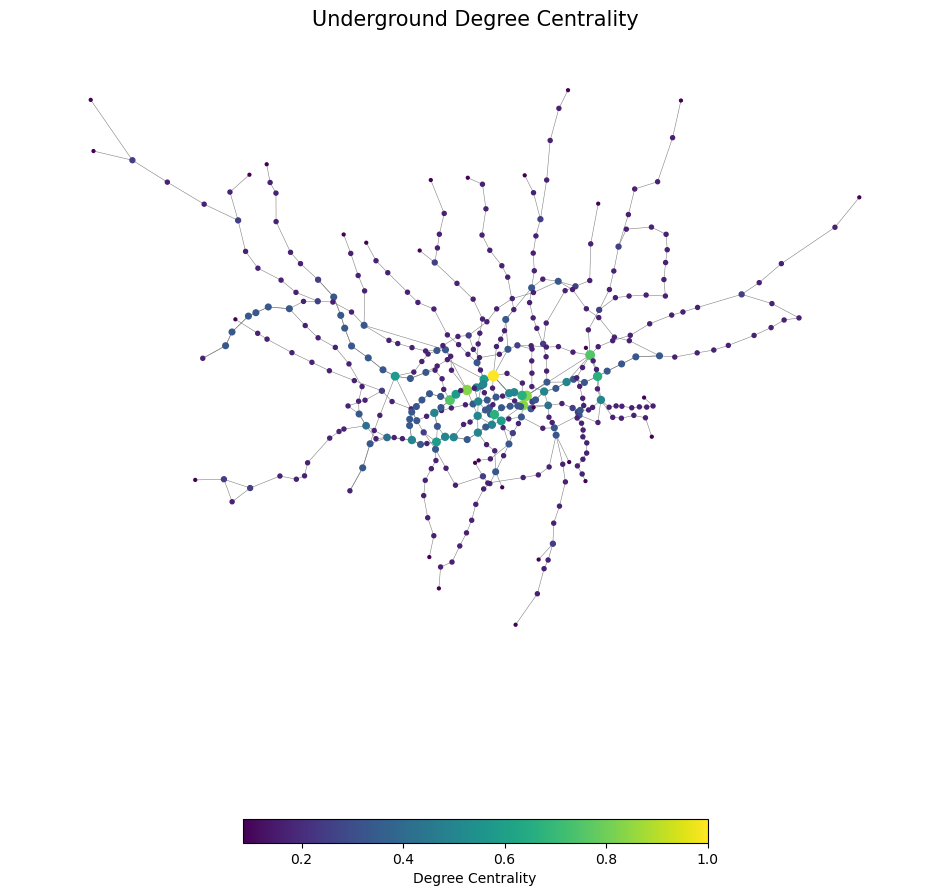

In [14]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]



# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Underground Degree Centrality",fontsize=15)
plt.show()

### Topological Betweenness Centrality

In [15]:
#Compute
bet_london_w=nx.betweenness_centrality(G,weight='length',normalized=True)

#Set attributes
nx.set_node_attributes(G,bet_london_w,'betweenness_w')

df = pd.DataFrame(index=G.nodes())
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))

df_sorted = df.sort_values(["betweenness_w"], ascending=False)

#Save for later
betweenness_top_fifteen = df_sorted[0:15]

df_sorted[0:10]

,betweenness_w
Bank and Monument,0.220576
King's Cross St. Pancras,0.210276
Stratford,0.182306
Baker Street,0.165414
Oxford Circus,0.157694
Euston,0.155401
Earl's Court,0.143534
Shadwell,0.139436
Waterloo,0.130414
South Kensington,0.129123


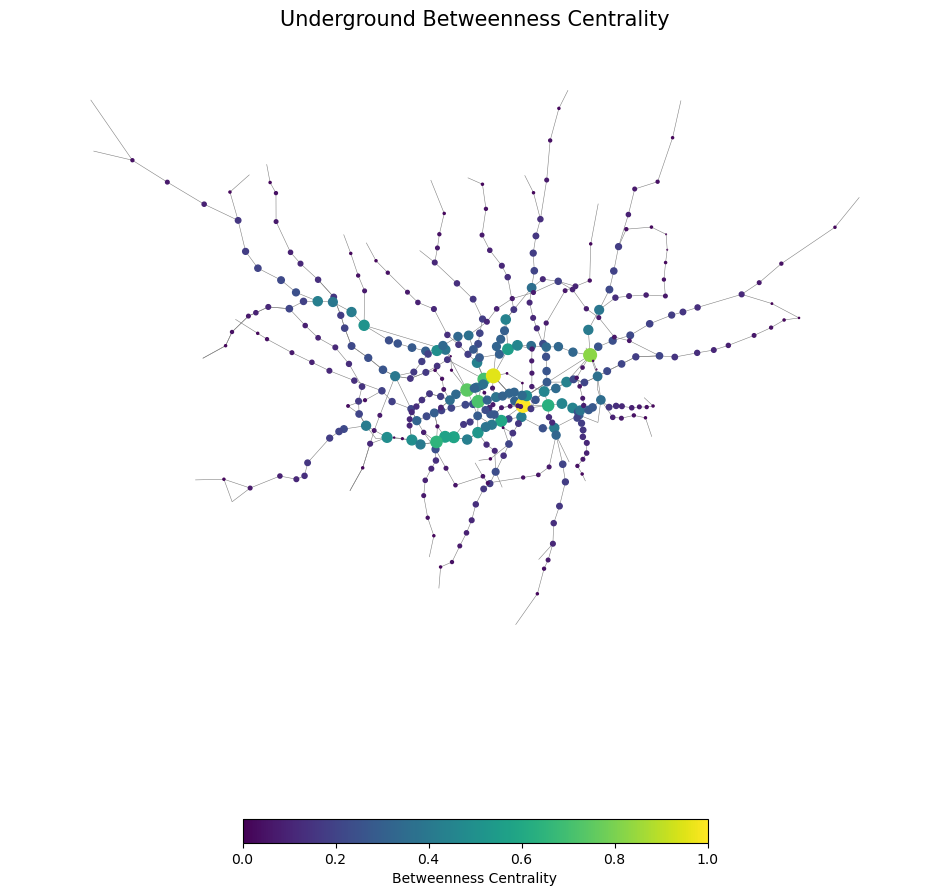

In [16]:
# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_w']) for i in G.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Underground Betweenness Centrality",fontsize=15)
plt.show()

### Eigenvector Centrality

In [17]:
#Compute
bet_london_w=nx.eigenvector_centrality(G_single, max_iter=1000)

#Set attributes
nx.set_node_attributes(G,bet_london_w,'eigenvector')

df = pd.DataFrame(index=G.nodes())
df['eigenvector'] = pd.Series(nx.get_node_attributes(G, 'eigenvector'))

df_sorted = df.sort_values(["eigenvector"], ascending=False)

#Save for later
eigenvector_top_fifteen = df_sorted[0:15]

df_sorted[0:10]

,eigenvector
Bank and Monument,0.383427
Liverpool Street,0.328824
Stratford,0.269179
Waterloo,0.249731
Moorgate,0.215137
Green Park,0.197630
Oxford Circus,0.184094
Tower Hill,0.171676
Westminster,0.168610
Shadwell,0.159090


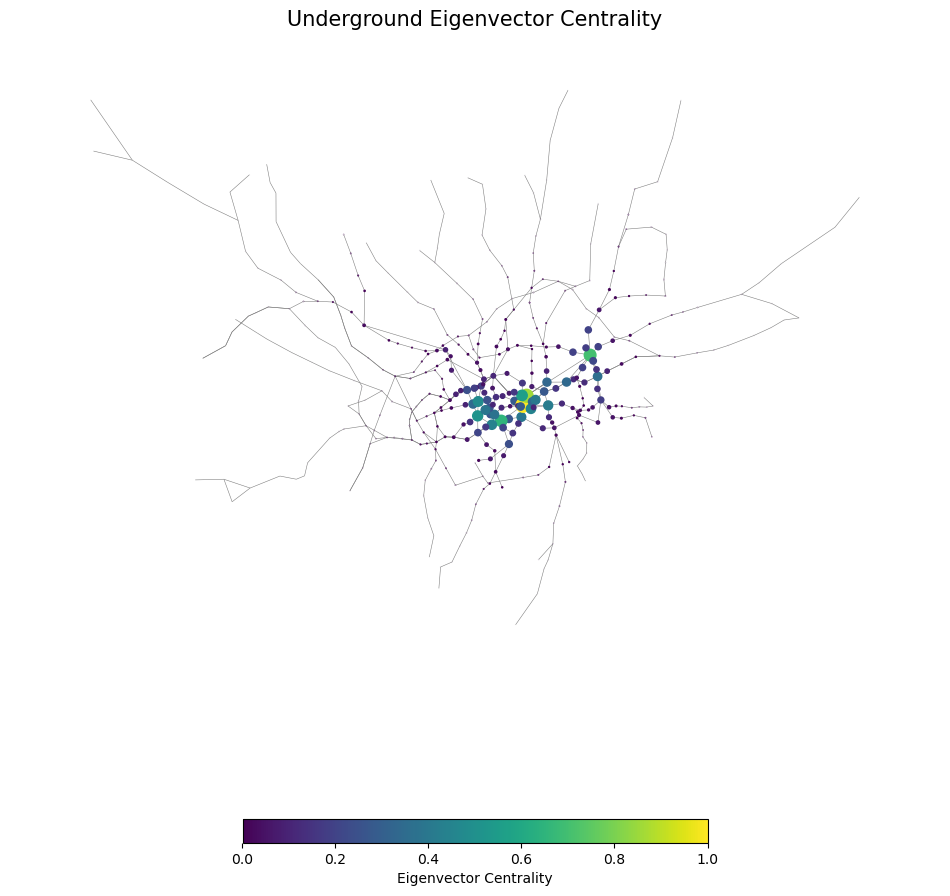

In [18]:
# Set colour and size of nodes according to eigenvector values
eigenvector_values=[(i[1]['eigenvector']) for i in G.nodes(data=True)]

bet_w_color=[(i[1]['eigenvector']/max(eigenvector_values)) for i in G.nodes(data=True)]
bet_w_size=[(i[1]['eigenvector']/max(eigenvector_values))*100 for i in G.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Eigenvector Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Underground Eigenvector Centrality",fontsize=15)
plt.show()

## Node Removal

In [19]:
#Function to calculate impact measures (avg transfers, L(p))

def calc_impacts(G, flow_tracker):
    """
    Function takes in a graph G after a node has been removed and calculates impact statistics to report back
    flow_tracker is just the dataframe of flows
    """
    
    #Add Flow Data - script taken from above

    #create a dictionary to store flows for all edges
    flows_ci = {(u, v, line_name): 0 for u, v in G.edges() if 'line_name' in G[u][v]}
    
    for i, row in flow_tracker.iterrows():
        source = row.station_origin
        target = row.station_destination

        if source == target:
            continue

        #get shortest path (edges computed)
        #2008 distance penalty derived from average speed of train and average transfer time
        path = dijkstra_transfer(G, source, target, 10000)

        #Get transfer count
        line_changes = 0
        previous_line = None

        for origin, destination, line_name in path:
            if previous_line is not None and line_name != previous_line:
                line_changes += 1
            previous_line = line_name

        #Add transfer count to station flow table
        flow_tracker.at[i, 'transfer_count'] = line_changes

        #Add path to station flow table
        flow_tracker.at[i, 'path'] = path
        
        flow_tracker.at[i, 'path_length'] = len(flow_tracker.at[i, 'path'])
            
            
    #Calculate L(P)
    L_p = flow_tracker['path_length'].mean()
    
    #Calculate Average Transfers
    avg_transfers = flow_tracker['transfer_count'].mean()
    
    
    return avg_transfers, L_p

In [20]:
#Non-Sequential - Degree
G_nsd = G.copy()
G_size = G_nsd.number_of_nodes()

#Baseline
average_t_base, L_p_base = calc_impacts(G_nsd, flows_for_later)

removal_nsd = degree_top_fifteen.copy()
flow_tracker = flows_for_later.copy()

#Init dataframe to store results
column_names = ['stations_removed_count', 'station_removed', 'L_p', 'average_t', 'connected']
results_table = pd.DataFrame(columns=column_names)

results_table.loc[0] = [0, 'N/a', L_p_base, average_t_base, 100]

for i in range(10):
    
    random_row = removal_nsd.sample()
    while not G_nsd.has_node(random_row.index[0]) :
        random_row = removal_nsd.sample()
        
    print(random_row)
    
    # Get the index label and the corresponding row value
    removed_station = random_row.index[0]
    random_index_label = random_row.values[0]
    
    #Drop from top ten list
    removal_nsd.drop(removed_station, inplace=True)
    
    #Update flow dataframe
    flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(removed_station) | flow_tracker['station_destination'].str.contains(removed_station))]
    
    #Remove station from graph
    G_nsd.remove_node(removed_station)
    
    #Calculate metrics
    if nx.is_connected(G_nsd):
        average_t, L_p = calc_impacts(G_nsd, flow_tracker)
        largest_comp_pct = G_nsd.number_of_nodes() * 100 / G_size
    else:
        connected_components = list(nx.connected_components(G_nsd))
        largest_component = max(connected_components, key=len)
        G_nsd = G_nsd.subgraph(largest_component).copy()
        
        #Reset flow_tracker
        connected_components.remove(largest_component)
        for component in connected_components[::1]:
            for node in component:
                #Do for each of the other components and all the stations in them
                flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(node) | flow_tracker['station_destination'].str.contains(node))]
        
        average_t, L_p = calc_impacts(G_nsd, flow_tracker)
        largest_comp_pct = G_nsd.number_of_nodes() * 100 / G_size
    
    #Fix input of connected as true
    results_table.loc[i+1] = [i+1, removed_station, L_p, average_t, largest_comp_pct]
    
results_table.head(11)



              abs_degree
Edgware Road         7.0
          abs_degree
Moorgate         8.0
                          abs_degree
King's Cross St. Pancras        12.0
        abs_degree
Euston         7.0
            abs_degree
Paddington         9.0
            abs_degree
Embankment         8.0
                   abs_degree
Bank and Monument        10.0
          abs_degree
West Ham         8.0
              abs_degree
Baker Street        10.0
           abs_degree
Stratford         9.0


,stations_removed_count,station_removed,L_p,average_t,connected
0,0,N/a,13.806849,1.026444,100.000000
1,1,Edgware Road,14.114226,1.066588,99.750623
2,2,Moorgate,14.207814,1.101770,99.501247
3,3,King's Cross St. Pancras,14.786991,1.255420,98.254364
4,4,Euston,14.462232,1.246002,92.518703
5,5,Paddington,14.447928,1.289640,92.269327
6,6,Embankment,14.248880,1.379305,92.019950
7,7,Bank and Monument,14.797954,1.538548,90.773067
8,8,West Ham,15.367250,1.608048,90.523691
9,9,Baker Street,16.129768,1.662571,89.526185


In [21]:
#Sequential - Degree
G_sd = G.copy()

removal_sd = degree_top_fifteen.copy()
flow_tracker = flows_for_later.copy()

#Init dataframe to store results
column_names = ['stations_removed_count', 'station_removed', 'L_p', 'average_t', 'connected']
results_table = pd.DataFrame(columns=column_names)

results_table.loc[0] = [0, 'N/a', L_p_base, average_t_base, 100]

for i in range(10):
    
    if i == 0:
        #Just highest centrality as already calculated
        row = removal_sd.head(1)
        print(row)
    else:
        #Recompute centrality measures
        deg_london = nx.degree_centrality(G_sd)
        nx.set_node_attributes(G,dict(deg_london),'degree')

        # Multiply centrality values by the total number of nodes - 1
        total_nodes = len(G_sd.nodes()) - 1
        absolute_deg_london = {node: centrality * total_nodes for node, centrality in deg_london.items()}

        #Set attributes
        nx.set_node_attributes(G_sd, absolute_deg_london, 'abs_degree')

        df = pd.DataFrame(index=G_sd.nodes())
        df['abs_degree'] = pd.Series(nx.get_node_attributes(G_sd, 'abs_degree'))

        df_sorted = df.sort_values(['abs_degree'], ascending=False)
        row = df_sorted.head(1)
        print(row)
        
    # Get the index label and the corresponding row value
    removed_station = row.index[0]
    random_index_label = row.values[0]
    
    #Update flow dataframe
    flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(removed_station) | flow_tracker['station_destination'].str.contains(removed_station))]
    
    #Remove station from graph
    G_sd.remove_node(removed_station)
    
    #Calculate metrics
    if nx.is_connected(G_sd):
        average_t, L_p = calc_impacts(G_sd, flow_tracker)
        largest_comp_pct = G_sd.number_of_nodes() * 100 / G_size
    else:
        connected_components = list(nx.connected_components(G_sd))
        largest_component = max(connected_components, key=len)
        G_sd = G_sd.subgraph(largest_component).copy()
        
        #Reset flow_tracker
        connected_components.remove(largest_component)
        for component in connected_components[::1]:
            for node in component:
                #Do for each of the other components and all the stations in them
                flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(node) | flow_tracker['station_destination'].str.contains(node))]
        
        average_t, L_p = calc_impacts(G_sd, flow_tracker)
        largest_comp_pct = G_sd.number_of_nodes() * 100 / G_size
    
    #Fix input of connected as true
    results_table.loc[i+1] = [i+1, removed_station, L_p, average_t, largest_comp_pct]

results_table.head(11)

                          abs_degree
King's Cross St. Pancras        12.0
                   abs_degree
Bank and Monument        10.0
              abs_degree
Baker Street        10.0
                  abs_degree
Liverpool Street         9.0
            abs_degree
Paddington         9.0
            abs_degree
Embankment         8.0
           abs_degree
Stratford         8.0
                    abs_degree
Willesden Junction         7.0
          abs_degree
West Ham         7.0
              abs_degree
Earl's Court         7.0


,stations_removed_count,station_removed,L_p,average_t,connected
0,0,N/a,13.806849,1.026444,100.000000
1,1,King's Cross St. Pancras,14.738568,1.231358,99.750623
2,2,Bank and Monument,15.338764,1.533478,99.501247
3,3,Baker Street,16.085199,1.605475,98.753117
4,4,Liverpool Street,15.887898,1.532725,97.256858
5,5,Paddington,15.837404,1.563874,96.508728
6,6,Embankment,15.702141,1.603874,95.261845
7,7,Stratford,15.210930,1.589962,89.775561
8,8,Willesden Junction,16.621187,1.870171,86.284289
9,9,West Ham,17.618329,1.933227,85.536160


In [22]:
#Non-Sequential - Betweenness
G_nsb = G.copy()

removal_nsb = betweenness_top_fifteen.copy()
flow_tracker = flows_for_later.copy()

#Init dataframe to store results
column_names = ['stations_removed_count', 'station_removed', 'L_p', 'average_t', 'connected']
results_table = pd.DataFrame(columns=column_names)

results_table.loc[0] = [0, 'N/a', L_p_base, average_t_base, 100]

for i in range(10):
    
    random_row = removal_nsb.sample()
    while not G_nsb.has_node(random_row.index[0]) :
        random_row = removal_nsb.sample()
        
    print(random_row)

    # Get the index label and the corresponding row value
    removed_station = random_row.index[0]
    random_index_label = random_row.values[0]
    
    #Drop from top ten list
    removal_nsb.drop(removed_station, inplace=True)
    
    #Update flow dataframe
    flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(removed_station) | flow_tracker['station_destination'].str.contains(removed_station))]
    
    #Remove station from graph
    G_nsb.remove_node(removed_station)
    
    #Calculate metrics
    if nx.is_connected(G_nsb):
        average_t, L_p = calc_impacts(G_nsb, flow_tracker)
        largest_comp_pct = G_nsb.number_of_nodes() * 100 / G_size
    else:
        connected_components = list(nx.connected_components(G_nsb))
        largest_component = max(connected_components, key=len)
        G_nsb = G_nsb.subgraph(largest_component).copy()
        
        #Reset flow_tracker
        connected_components.remove(largest_component)
        for component in connected_components[::1]:
            for node in component:
                #Do for each of the other components and all the stations in them
                flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(node) | flow_tracker['station_destination'].str.contains(node))]
        
        average_t, L_p = calc_impacts(G_nsb, flow_tracker)
        largest_comp_pct = G_nsb.number_of_nodes() * 100 / G_size
    
    #Fix input of connected as true
    results_table.loc[i+1] = [i+1, removed_station, L_p, average_t, largest_comp_pct]

results_table.head(11)

                          betweenness_w
King's Cross St. Pancras       0.210276
               betweenness_w
Oxford Circus       0.157694
              betweenness_w
Earl's Court       0.143534
              betweenness_w
Wembley Park        0.11317
              betweenness_w
Baker Street       0.165414
        betweenness_w
Euston       0.155401
                 betweenness_w
Gloucester Road       0.127256
                   betweenness_w
Bank and Monument       0.220576
             betweenness_w
Hammersmith       0.108471
                      betweenness_w
Highbury & Islington       0.123133


,stations_removed_count,station_removed,L_p,average_t,connected
0,0,N/a,13.806849,1.026444,100.000000
1,1,King's Cross St. Pancras,14.738568,1.231358,99.750623
2,2,Oxford Circus,15.082163,1.250696,99.501247
3,3,Earl's Court,15.327941,1.409793,99.251870
4,4,Wembley Park,16.376404,1.503719,98.004988
5,5,Baker Street,16.612197,1.552209,97.007481
6,6,Euston,16.652244,1.619615,91.271820
7,7,Gloucester Road,16.490486,1.911680,91.022444
8,8,Bank and Monument,17.010192,2.131945,90.773067
9,9,Hammersmith,16.877961,2.168650,90.024938


In [23]:
#Sequential - Betweenness
G_sb = G.copy()

removal_sb = betweenness_top_fifteen.copy()
flow_tracker = flows_for_later.copy()

#Init dataframe to store results
column_names = ['stations_removed_count', 'station_removed', 'L_p', 'average_t', 'connected']
results_table = pd.DataFrame(columns=column_names)

results_table.loc[0] = [0, 'N/a', L_p_base, average_t_base, 100]

for i in range(10):
    
    if i == 0:
        #Just highest centrality as already calculated
        row = removal_sb.head(1)
        print(row)
    else:
        #Recompute centrality
        bet_london_w=nx.betweenness_centrality(G_sb, weight='length',normalized=False)

        #Set attributes
        nx.set_node_attributes(G_sb,bet_london_w,'betweenness_w')

        df = pd.DataFrame(index=G_sb.nodes())
        df['betweenness_w'] = pd.Series(nx.get_node_attributes(G_sb, 'betweenness_w'))

        df_sorted = df.sort_values(["betweenness_w"], ascending=False)
    
        row = df_sorted.head(1)
        print(row)
    
    # Get the index label and the corresponding row value
    removed_station = row.index[0]
    random_index_label = row.values[0]
    
    #Update flow dataframe
    flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(removed_station) | flow_tracker['station_destination'].str.contains(removed_station))]
    
    #Remove station from graph
    G_sb.remove_node(removed_station)
    
    #Calculate metrics
    if nx.is_connected(G_sb):
        average_t, L_p = calc_impacts(G_sb, flow_tracker)
        largest_comp_pct = G_sb.number_of_nodes() * 100 / G_size
    else:
        connected_components = list(nx.connected_components(G_sb))
        largest_component = max(connected_components, key=len)
        G_sb = G_sb.subgraph(largest_component).copy()
        
        #Reset flow_tracker
        connected_components.remove(largest_component)
        for component in connected_components[::1]:
            for node in component:
                #Do for each of the other components and all the stations in them
                flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(node) | flow_tracker['station_destination'].str.contains(node))]
        
        average_t, L_p = calc_impacts(G_sb, flow_tracker)
        largest_comp_pct = G_sb.number_of_nodes() * 100 / G_size
    
    #Fix input of connected as true
    results_table.loc[i+1] = [i+1, removed_station, L_p, average_t, largest_comp_pct]

results_table.head(11)



                   betweenness_w
Bank and Monument       0.220576
                          betweenness_w
King's Cross St. Pancras        24037.0
              betweenness_w
Canada Water        26983.0
                betweenness_w
West Hampstead        40647.0
              betweenness_w
Earl's Court         8226.0
               betweenness_w
Oxford Circus         8911.0
                 betweenness_w
Shepherd's Bush         8523.0
              betweenness_w
Baker Street         7648.0
            betweenness_w
Acton Town         8784.0
        betweenness_w
Euston         3346.0


,stations_removed_count,station_removed,L_p,average_t,connected
0,0,N/a,13.806849,1.026444,100.000000
1,1,Bank and Monument,13.997352,1.186481,99.750623
2,2,King's Cross St. Pancras,15.338764,1.533478,99.501247
3,3,Canada Water,16.762886,1.564833,99.251870
4,4,West Hampstead,12.068943,1.199905,56.857855
5,5,Earl's Court,12.569029,1.408800,56.608479
6,6,Oxford Circus,12.974900,1.464795,56.359102
7,7,Shepherd's Bush,13.822619,1.516578,48.877805
8,8,Baker Street,17.145833,1.808821,47.880299
9,9,Acton Town,11.527487,1.212873,31.421446


In [24]:
#Non-Sequential - Eigenvector
G_nse = G.copy()

removal_nse = eigenvector_top_fifteen.copy()
flow_tracker = flows_for_later.copy()

#Init dataframe to store results
column_names = ['stations_removed_count', 'station_removed', 'L_p', 'average_t', 'connected']
results_table = pd.DataFrame(columns=column_names)

results_table.loc[0] = [0, 'N/a', L_p_base, average_t_base, 100]

for i in range(10):
    
    random_row = removal_nse.sample()
    while not G_nsb.has_node(random_row.index[0]) :
        random_row = removal_nse.sample()
        
    print(random_row)

    # Get the index label and the corresponding row value
    removed_station = random_row.index[0]
    random_index_label = random_row.values[0]
    
    #Drop from top ten list
    removal_nse.drop(removed_station, inplace=True)
    
    #Update flow dataframe
    flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(removed_station) | flow_tracker['station_destination'].str.contains(removed_station))]
    
    #Remove station from graph
    G_nse.remove_node(removed_station)
    
    connected = True
    
    #Calculate metrics
    if nx.is_connected(G_nse):
        average_t, L_p = calc_impacts(G_nse, flow_tracker)
        largest_comp_pct = G_nse.number_of_nodes() * 100 / G_size
    else:
        connected_components = list(nx.connected_components(G_nse))
        largest_component = max(connected_components, key=len)
        G_nse = G_nse.subgraph(largest_component).copy()
        
        #Reset flow_tracker
        connected_components.remove(largest_component)
        for component in connected_components[::1]:
            for node in component:
                #Do for each of the other components and all the stations in them
                flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(node) | flow_tracker['station_destination'].str.contains(node))]
        
        average_t, L_p = calc_impacts(G_nse, flow_tracker)
        largest_comp_pct = G_nse.number_of_nodes() * 100 / G_size
    
    #Fix input of connected as true
    results_table.loc[i+1] = [i+1, removed_station, L_p, average_t, largest_comp_pct]

results_table.head(11)



            eigenvector
Embankment     0.144496
          eigenvector
Waterloo     0.249731
             eigenvector
Westminster      0.16861
            eigenvector
Green Park      0.19763
            eigenvector
Tower Hill     0.171676
           eigenvector
Stratford     0.269179
          eigenvector
Shadwell      0.15909
                   eigenvector
Piccadilly Circus     0.149899
              eigenvector
Aldgate East     0.155374
          eigenvector
West Ham     0.137281


,stations_removed_count,station_removed,L_p,average_t,connected
0,0,N/a,13.806849,1.026444,100.000000
1,1,Embankment,13.738137,1.083389,99.750623
2,2,Waterloo,13.969515,1.110426,99.501247
3,3,Westminster,13.980813,1.108857,99.251870
4,4,Green Park,14.265508,1.184458,99.002494
5,5,Tower Hill,14.191506,1.230423,98.753117
6,6,Stratford,13.887286,1.241803,93.266833
7,7,Shadwell,13.887464,1.255929,92.768080
8,8,Piccadilly Circus,13.925409,1.256484,92.518703
9,9,Aldgate East,13.859743,1.268320,92.269327


In [25]:
#Sequential - Eigenvector
G_se = G.copy()
G_se_single = G_single.copy()

removal_se = eigenvector_top_fifteen.copy()
flow_tracker = flows_for_later.copy()

#Init dataframe to store results
column_names = ['stations_removed_count', 'station_removed', 'L_p', 'average_t', 'connected']
results_table = pd.DataFrame(columns=column_names)

results_table.loc[0] = [0, 'N/a', L_p_base, average_t_base, 100]

for i in range(10):
    
    if i == 0:
        #Just highest centrality as already calculated
        row = removal_se.head(1)
        print(row)
    else:
        #Compute
        bet_london_w=nx.eigenvector_centrality(G_se_single, max_iter=1000)

        #Set attributes
        nx.set_node_attributes(G_se_single,bet_london_w,'eigenvector')

        df = pd.DataFrame(index=G_se_single.nodes())
        df['eigenvector'] = pd.Series(nx.get_node_attributes(G_se_single, 'eigenvector'))

        df_sorted = df.sort_values(["eigenvector"], ascending=False)

        row = df_sorted.head(1)
        print(row)
    
    # Get the index label and the corresponding row value
    removed_station = row.index[0]
    random_index_label = row.values[0]
    
    
    #Update flow dataframe
    flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(removed_station) | flow_tracker['station_destination'].str.contains(removed_station))]
    
    #Remove station from graph
    G_se.remove_node(removed_station)
    G_se_single.remove_node(removed_station)
    
    connected = True
    
    #Calculate metrics
    if nx.is_connected(G_se):
        average_t, L_p = calc_impacts(G_se, flow_tracker)
        largest_comp_pct = G_se.number_of_nodes() * 100 / G_size
    else:
        connected_components = list(nx.connected_components(G_se))
        largest_component = max(connected_components, key=len)
        G_se = G_se.subgraph(largest_component).copy()
        
        #Reset flow_tracker
        connected_components.remove(largest_component)
        for component in connected_components[::1]:
            for node in component:
                #Do for each of the other components and all the stations in them
                flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(node) | flow_tracker['station_destination'].str.contains(node))]
        
        average_t, L_p = calc_impacts(G_se, flow_tracker)
        largest_comp_pct = G_se.number_of_nodes() * 100 / G_size
    
    #Fix input of connected as true
    results_table.loc[i+1] = [i+1, removed_station, L_p, average_t, largest_comp_pct]

results_table.head(11)

                   eigenvector
Bank and Monument     0.383427
               eigenvector
Oxford Circus     0.416543
           eigenvector
Stratford     0.530685
              eigenvector
Earl's Court     0.411513
             eigenvector
Westminster     0.316724
              eigenvector
Baker Street     0.427186
                          eigenvector
King's Cross St. Pancras     0.516549
              eigenvector
Canning Town     0.530726
               eigenvector
Turnham Green     0.538152
                  eigenvector
Leicester Square     0.420549


,stations_removed_count,station_removed,L_p,average_t,connected
0,0,N/a,13.806849,1.026444,100.000000
1,1,Bank and Monument,13.997352,1.186481,99.750623
2,2,Oxford Circus,14.127279,1.195016,99.501247
3,3,Stratford,13.713310,1.134116,94.014963
4,4,Earl's Court,13.975356,1.291830,93.765586
5,5,Westminster,14.289333,1.388204,93.516209
6,6,Baker Street,15.528533,1.647437,93.017456
7,7,King's Cross St. Pancras,16.645118,1.859685,92.269327
8,8,Canning Town,16.854481,1.915353,88.778055
9,9,Turnham Green,17.079136,2.131818,88.528678


## Results Analysis

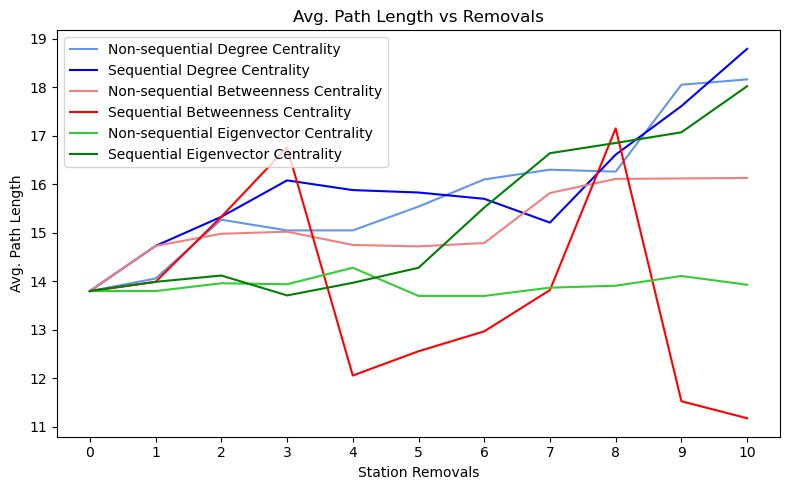

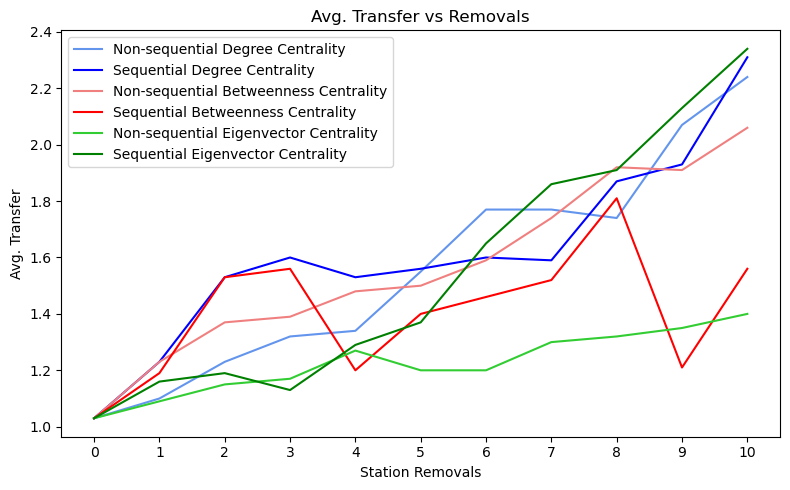

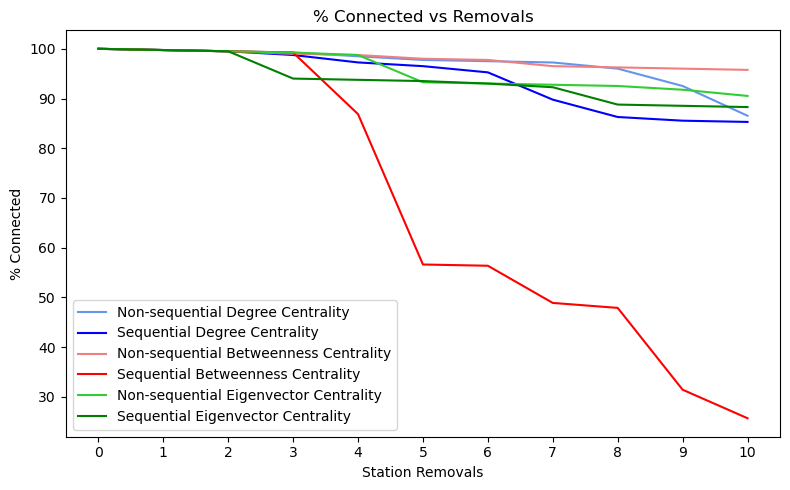

In [26]:
#Saved Table CSVs from first run so tables above may not reflect reported results


#nsd_results = pd.read_csv("./Data/nsd.csv")
#sd_results = pd.read_csv("./Data/sd.csv")
#nsb_results = pd.read_csv("./Data/nsb.csv")
#sb_results = pd.read_csv("./Data/sb.csv")
#nse_results = pd.read_csv("./Data/nse.csv")
#se_results = pd.read_csv("./Data/se.csv")

filenames = ['nsd_results.csv', 'sd_results.csv', 'nsb_results.csv', 
             'sb_results.csv', 'nse_results.csv', 'se_results.csv']
                         
dfs = [nsd_results, sd_results, nsb_results, sb_results, nse_results, se_results]


# Plotting
categories = ['Avg. Path Length', 'Avg. Transfer', '% Connected']
colors = ['cornflowerblue', 'blue', 'lightcoral', 'red', 'limegreen', 'green']

# Iterate over each category
for category in categories:
    # Create a new plot for the category
    plt.figure(figsize=(8, 5))
    plt.title(f'{category} vs Removals')
    plt.xlabel('Station Removals')
    plt.ylabel(category)
    
    labels = ["Non-sequential Degree Centrality", "Sequential Degree Centrality", 
              "Non-sequential Betweenness Centrality", "Sequential Betweenness Centrality", 
              "Non-sequential Eigenvector Centrality", "Sequential Eigenvector Centrality"]
    
    # Plot each scenario for the category
    for idx, df in enumerate(dfs):
        plt.plot(df['Removals'], df[category], color=colors[idx], label=labels[idx])

    plt.legend()
    plt.tight_layout()
    plt.show()

## Flow Sensitive Impact Analysis

In [27]:
#Recompute betweenness centrality metrics with flow weighting

G2 = G.copy()

#Invert weights
for u, v, d in G2.edges(data=True):
    d['flows_inv'] =  1 / (d.get('flows', 0) + .001)

#Compute
bet_london_w = nx.betweenness_centrality(G2,weight='flows_inv',normalized=True)

#Set attributes
nx.set_node_attributes(G,bet_london_w,'betweenness_f')

df = pd.DataFrame(index=G2.nodes())
df['betweenness_f'] = pd.Series(nx.get_node_attributes(G, 'betweenness_f'))

df_sorted = df.sort_values(["betweenness_f"], ascending=False)

#Save for later
flow_betweenness_top_ten = df_sorted[0:15]

flow_betweenness_top_ten

,betweenness_f
Bank and Monument,0.438847
King's Cross St. Pancras,0.420965
Holborn,0.364975
Chancery Lane,0.358434
St. Paul's,0.357544
Liverpool Street,0.302644
Stratford,0.299850
Baker Street,0.281642
Oxford Circus,0.261516
Russell Square,0.254612


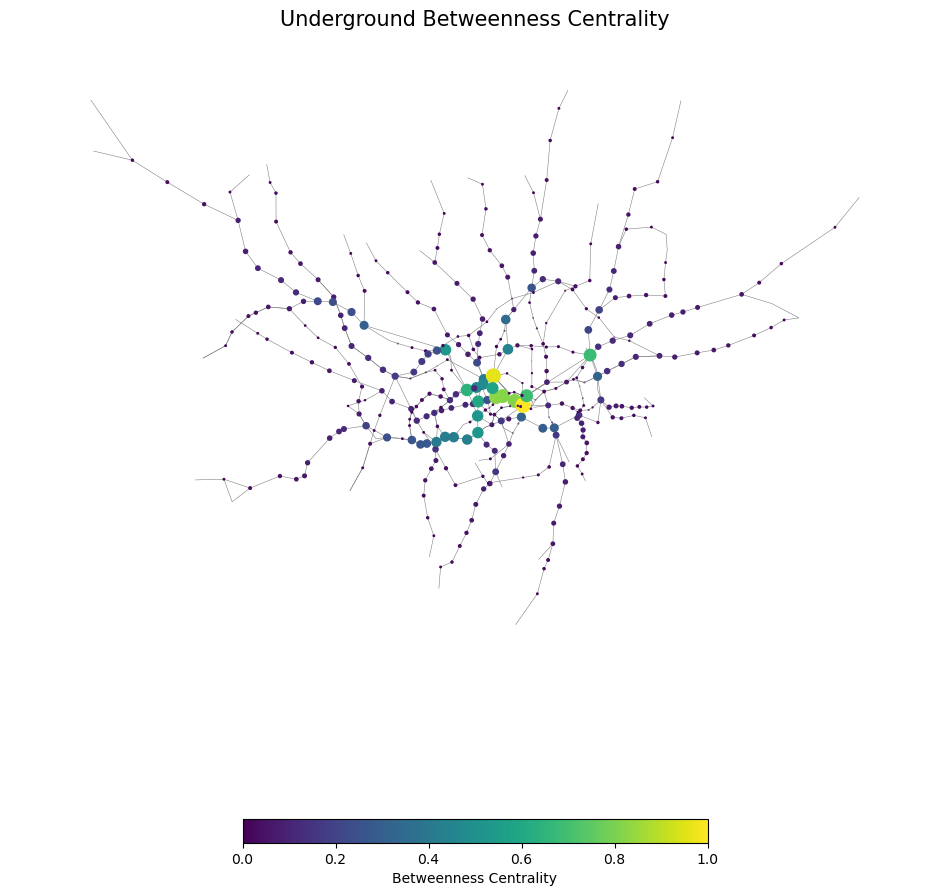

In [28]:

# Lets set colour and size of nodes according to betweenness values
betweenness_f_values=[(i[1]['betweenness_f']) for i in G.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_f']/max(betweenness_f_values)) for i in G.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_f']/max(betweenness_f_values))*100 for i in G.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Underground Betweenness Centrality",fontsize=15)
plt.show()

In [29]:
def calc_flow_impact(G, flow_tracker):
    """
    Function takes in a graph G after a node has been removed and calculates flow-sensitive impact statistics to report back
    flow_tracker is just the dataframe of flows
    """
    
    #Add Flow Data - script taken from above

    #create a dictionary to store flows for all edges
    flows_ci = {(u, v, line_name): 0 for u, v in G.edges() if 'line_name' in G[u][v]}
    
    for i, row in flow_tracker.iterrows():
        source = row.station_origin
        target = row.station_destination

        if source == target:
            continue

        #get shortest path (edges computed)
        #2008 distance penalty derived from average speed of train and average transfer time
        path = dijkstra_transfer(G, source, target, 10000)
        
        #Get transfer count
        line_changes = 0
        previous_line = None

        for origin, destination, line_name in path:
            if previous_line is not None and line_name != previous_line:
                line_changes += 1
            previous_line = line_name

        #Add transfer count to station flow table
        flow_tracker.at[i, 'transfer_count'] = line_changes

        #Add path to station flow table
        flow_tracker.at[i, 'path'] = path
        
        flow_tracker.at[i, 'path_length'] = len(flow_tracker.at[i, 'path'])
        
        #Recalculate Flows:
        for u, v, line_name in path:
            if (u, v) in G.edges():
                key = (u, v, line_name)
            else:
                key = (v, u, line_name)
            # Increment flow value
            flows_ci[key] = flows_ci.get(key, 0) + row.flows
            
    # Update flows in Graph
    for route_info, flow_count in flows_ci.items():
        origin, destination, line_name = route_info
        if G.has_edge(origin, destination):
            # Get all edges between origin and destination
            edges = G.edges(origin, destination, keys=True)

            # Check each edge for the matching line_name attribute
            for u, v, keys, data in edges:
                data = G.get_edge_data(u, v, key=keys)
                if data and 'line_name' in data and data['line_name'] == line_name:
                    # Update the 'flows' attribute for the edge with matching line_name
                    if u == origin and v == destination:
                        G[u][v][keys]['flows'] = flow_count

    #Calculate Busiest Section (flow)
    max_flow_count = max(flows_ci.values())

    #Calculate Busiest Section (name)
    max_flow_route = [key for key, value in flows_ci.items() if value == max_flow_count]
    
    #Calculate Average Transfers
    pc_transfers = (flow_tracker['transfer_count'] * flow_tracker['flows']).sum() / flow_tracker['flows'].sum()
    
    #Have to return graph to return updated flows
    return G, pc_transfers, max_flow_route, max_flow_count

In [30]:
#Unweighted Betweenness Centrality
G_sb2 = G.copy()
flow_tracker = flows_for_later.copy()

#Baseline
G_return, pc_t_base, busiest_route_base, busiest_count_base = calc_flow_impact(G_sb2, flows_for_later)

removal_sb = betweenness_top_fifteen.copy()
flow_tracker = flows_for_later.copy()

#Init dataframe to store results
column_names = ['stations_removed_count', 'station_removed', 'busiest_route', 'busiest_count', 'pc_t']
results_table = pd.DataFrame(columns=column_names)

results_table.loc[0] = [0, 'N/a', busiest_route_base, busiest_count_base, pc_t_base]

for i in range(3):
    
    if i == 0:
        #Just highest centrality as already calculated
        row = removal_sb.head(1)
        print(removal_sb.head(10))
        print(row)
    else:
        #Recompute centrality
        bet_london_w=nx.betweenness_centrality(G_sb2, weight='length',normalized=False)

        #Set attributes
        nx.set_node_attributes(G_sb2,bet_london_w,'betweenness_w')

        df = pd.DataFrame(index=G_sb2.nodes())
        df['betweenness_w'] = pd.Series(nx.get_node_attributes(G_sb2, 'betweenness_w'))

        df_sorted = df.sort_values(["betweenness_w"], ascending=False)
    
        row = df_sorted.head(1)
        print(df_sorted.head(10))
        print(row)
    
    # Get the index label and the corresponding row value
    removed_station = row.index[0]
    random_index_label = row.values[0]
    
    #Update flow dataframe
    flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(removed_station) | flow_tracker['station_destination'].str.contains(removed_station))]
    
    #Remove station from graph
    G_sb2.remove_node(removed_station)
    
    #Calculate metrics
    if not nx.is_connected(G_sb2):
        connected_components = list(nx.connected_components(G_sb2))
        largest_component = max(connected_components, key=len)
        G_sb2 = G_sb2.subgraph(largest_component).copy()
        
        #Reset flow_tracker
        connected_components.remove(largest_component)
        for component in connected_components[::1]:
            for node in component:
                #Do for each of the other components and all the stations in them
                flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(node) | flow_tracker['station_destination'].str.contains(node))]
        
    G_return, pc_t, busiest_route, busiest_count = calc_flow_impact(G_sb2, flow_tracker)
    #largest_comp_pct = G_sb2.number_of_nodes() * 100 / G_size
    
    #Replace graph with new flows
    G_sb2 = G_return.copy()
    
    #Fix input of connected as true
    results_table.loc[i+1] = [i+1, removed_station, busiest_route, busiest_count, pc_t]

results_table.head(4)


                          betweenness_w
Bank and Monument              0.220576
King's Cross St. Pancras       0.210276
Stratford                      0.182306
Baker Street                   0.165414
Oxford Circus                  0.157694
Euston                         0.155401
Earl's Court                   0.143534
Shadwell                       0.139436
Waterloo                       0.130414
South Kensington               0.129123
                   betweenness_w
Bank and Monument       0.220576
                          betweenness_w
King's Cross St. Pancras        24037.0
Baker Street                    16162.0
Stratford                       14567.0
Euston                          14061.0
Canada Water                    13444.0
Highbury & Islington            13028.0
Whitechapel                     11938.0
Canonbury                       11218.0
Waterloo                        11130.0
Oxford Circus                   11102.0
                          betweenness_w
King's Cross S

,stations_removed_count,station_removed,busiest_route,busiest_count,pc_t
0,0,N/a,"[(Camden Town, Euston, Northern)]",55970,0.344678
1,1,Bank and Monument,"[(King's Cross St. Pancras, Russell Square, Pi...",66654,0.478530
2,2,King's Cross St. Pancras,"[(Bermondsey, London Bridge, Jubilee)]",129362,0.898502
3,3,Canada Water,"[(Gospel Oak, Hampstead Heath, London Overgrou...",233677,0.960036


                          betweenness_f
Bank and Monument              0.438847
King's Cross St. Pancras       0.420965
Holborn                        0.364975
Chancery Lane                  0.358434
St. Paul's                     0.357544
Liverpool Street               0.302644
Stratford                      0.299850
Baker Street                   0.281642
Oxford Circus                  0.261516
Russell Square                 0.254612
                   betweenness_f
Bank and Monument       0.438847


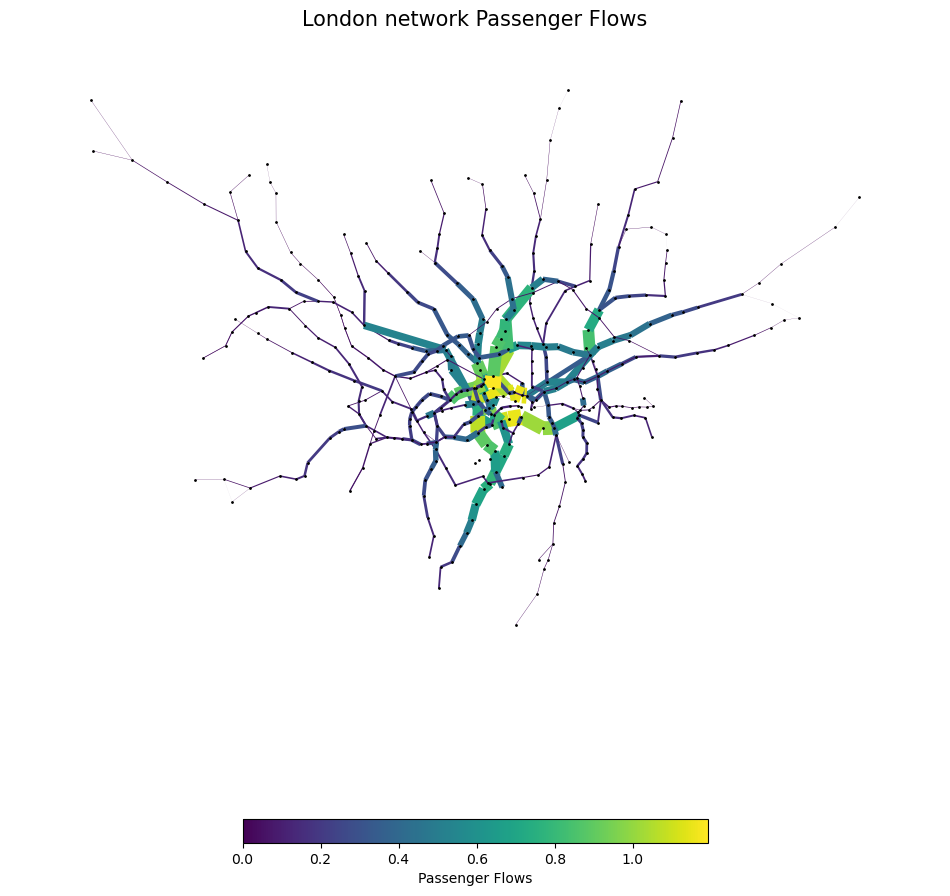

                          betweenness_f
King's Cross St. Pancras        41273.0
Green Park                      26785.0
Baker Street                    26497.0
Farringdon                      24594.0
Barbican                        24389.0
Moorgate                        24280.0
Liverpool Street                24047.0
Euston                          23882.0
Finchley Road                   18735.0
Warren Street                   17965.0
                          betweenness_f
King's Cross St. Pancras        41273.0


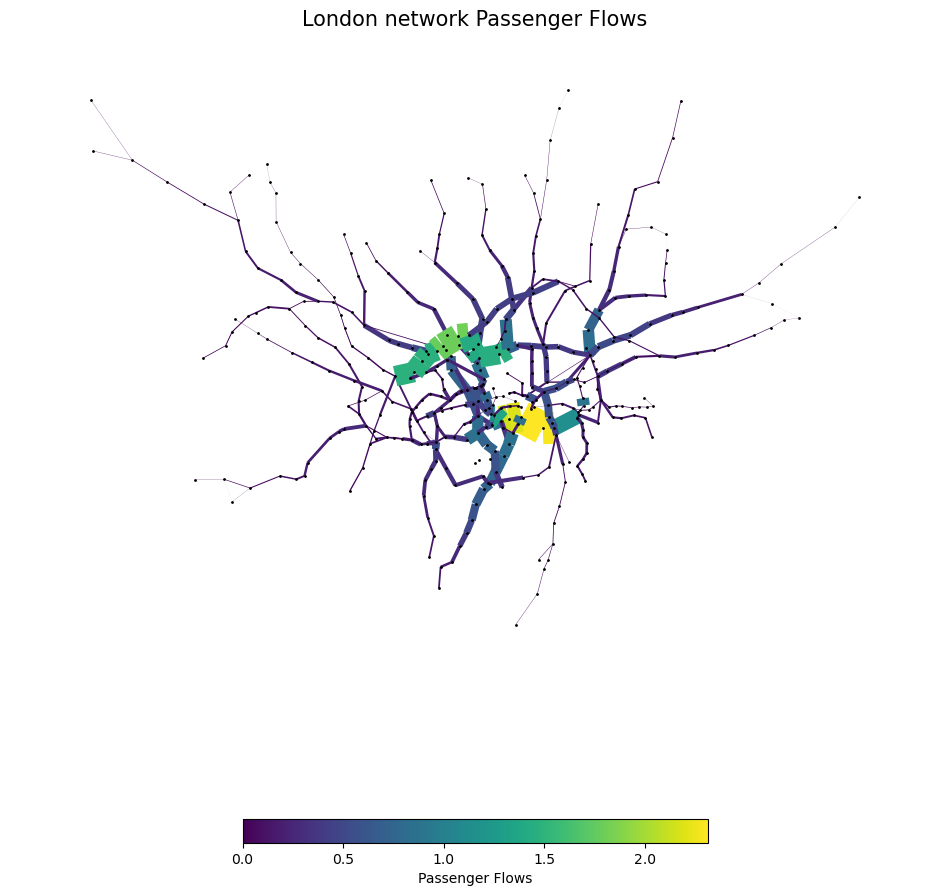

                         betweenness_f
Canada Water                   25573.0
Waterloo                       25062.0
West Hampstead                 24711.0
London Bridge                  22411.0
Southwark                      22366.0
Bermondsey                     22057.0
Green Park                     20894.0
Gospel Oak                     20149.0
Finchley Road & Frognal        19305.0
Hampstead Heath                19205.0
              betweenness_f
Canada Water        25573.0


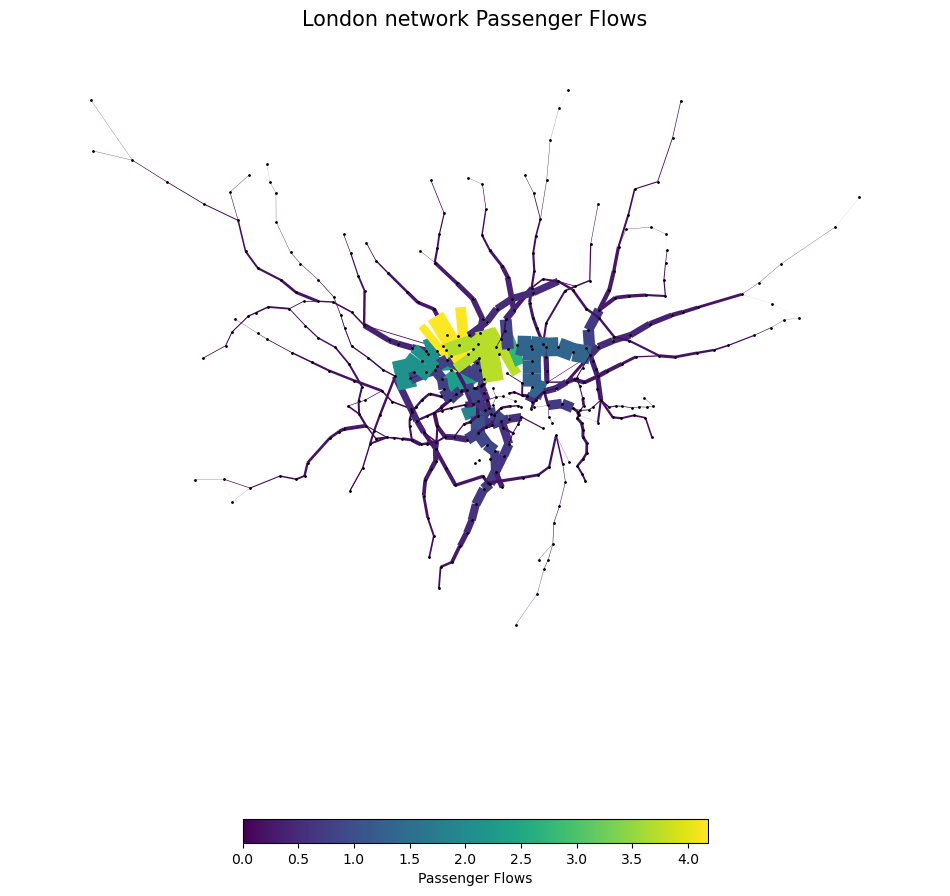

,stations_removed_count,station_removed,busiest_route,busiest_count,pc_t
1,1,Bank and Monument,"[(King's Cross St. Pancras, Russell Square, Pi...",66654,0.478530
2,2,King's Cross St. Pancras,"[(Bermondsey, London Bridge, Jubilee)]",129362,0.898502
3,3,Canada Water,"[(Gospel Oak, Hampstead Heath, London Overgrou...",233677,0.960036


In [31]:
#Flow Betweenness Centrality
G_fb = G.copy()
flow_tracker = flows_for_later.copy()

removal_sb = flow_betweenness_top_ten.copy()
flow_tracker = flows_for_later.copy()

#Init dataframe to store results
column_names = ['stations_removed_count', 'station_removed', 'busiest_route', 'busiest_count', 'pc_t']
results_table = pd.DataFrame(columns=column_names)

#results_table.loc[0] = [0, 'N/a', busiest_route_base, busiest_count_base, pc_t_base]

for i in range(3):
    
    if i == 0:
        #Just highest centrality as already calculated
        row = removal_sb.head(1)
        print(removal_sb.head(10))
        print(row)
    else:
        #Invert weights
        for u, v, d in G_fb.edges(data=True):
            d['flows_inv'] =  1/ (d.get('flows', 0) + .001)
        
        #Recompute centrality
        bet_london_f = nx.betweenness_centrality(G_fb, weight='flows_inv',normalized=False)

        #Set attributes
        nx.set_node_attributes(G_fb,bet_london_f,'betweenness_f')

        df = pd.DataFrame(index=G_fb.nodes())
        df['betweenness_f'] = pd.Series(nx.get_node_attributes(G_fb, 'betweenness_f'))

        df_sorted = df.sort_values(["betweenness_f"], ascending=False)
        print(df_sorted.head(10))
        row = df_sorted.head(1)
        print(row)
    
    # Get the index label and the corresponding row value
    removed_station = row.index[0]
    random_index_label = row.values[0]
    
    #Update flow dataframe
    flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(removed_station) | flow_tracker['station_destination'].str.contains(removed_station))]
    
    #Remove station from graph
    G_fb.remove_node(removed_station)
    
    #Calculate metrics
    if not nx.is_connected(G_fb):
        connected_components = list(nx.connected_components(G_fb))
        largest_component = max(connected_components, key=len)
        G_fb = G_fb.subgraph(largest_component).copy()
        
        #Reset flow_tracker
        connected_components.remove(largest_component)
        for component in connected_components[::1]:
            for node in component:
                #Do for each of the other components and all the stations in them
                flow_tracker = flow_tracker[~(flow_tracker['station_origin'].str.contains(node) | flow_tracker['station_destination'].str.contains(node))]
        
    G_return, pc_t, busiest_route, busiest_count = calc_flow_impact(G_fb, flow_tracker)
    #largest_comp_pct = G_fb.number_of_nodes() * 100 / G_size
    
    #Replace graph with new flows
    G_sb2 = G_return.copy()
    
    #Fix input of connected as true
    results_table.loc[i+1] = [i+1, removed_station, busiest_route, busiest_count, pc_t]
    
    # Plot flows to sanity check
    
    # Plot calculated flows
    flow_color = [(data.get('flows', 0) / max(flows_values)) for _, _, data in G_fb.edges(data=True)]
    flow_width = [(data.get('flows', 0) / max(flows_values) * 10) for _, _, data in G_fb.edges(data=True)]

    # Plot graph
    fig, ax = plt.subplots(figsize=(12,12))

    #pos=nx.spring_layout(X)
    edg=nx.draw_networkx_edges(G_fb, pos,edge_color=flow_color, width=flow_width)

    #For plot below
    if i == 0:
        post_bank = G_fb.copy()
    
    nx.draw_networkx_nodes(G_fb,
            pos = pos,
            node_color= 'black',
            node_size= 1)

    plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
    plt.axis("off")
    plt.title("London network Passenger Flows",fontsize=15)
    plt.show()
    

results_table.head(4)

In [33]:
#Plot difference - this does not work FYI
G_diff = G.copy()

for source, target, data in G_diff.edges(data=True):
    # Check if the edge exists in post_bank_
    if post_bank_.has_edge(source, target):
        # Check if 'line_name' attribute matches
        try:
            if data['line_name'] == post_bank_.edges[source, target]['line_name']:
                # Subtract 'flows' attributes
                post_bank_.edges[source, target]['flows'] = G_diff.edges[source, target]['flows'] - post_bank_.edges[source, target]['flows']
        except ValueError:
            pass
        
# Plot calculated flows
flow_color = [(data.get('flows', 0) / max(flows_values)) for _, _, data in post_bank_.edges(data=True)]
flow_width = [(data.get('flows', 0) / max(flows_values) * 10) for _, _, data in post_bank_.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(post_bank_, pos,edge_color=flow_color, width=flow_width)

#For plot below
if i == 0:
    post_bank_ = G_fb
    
nx.draw_networkx_nodes(G_,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()


NameError: name 'post_bank_' is not defined

# Part II - Spatial Interaction Models

Data Loading & Preprocessing

In [35]:
#Reading in flows
flows = pd.read_csv("./Data/london_flows.csv")

#Check data loaded
flows.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [36]:
#Metric Calculations(Taken from Prac3)
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(np.sqrt(res.mean()), 3)
    
    return RMSE

Set up Origin Constrained Model with Exponential Decay.

I will use population as our origin mass factor and employment count as our destination mass factor to simulate maximum commute flow during the morning rush.

In [37]:
#Calculate log of destination employment count with small addition to solve div by zero error
flows['log_dest_jobs'] = np.log(flows['jobs'] + .001)

#Formula for origin constrained equation (with exponential decay)
eq_form = 'flows ~ station_origin + log_dest_jobs + distance-1'

#Doubly Constrained Model with smf
sim = smf.glm(formula = eq_form, data = flows, family=sm.families.Poisson()).fit()

print(sim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61451
Model:                            GLM   Df Residuals:                    61051
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2195e+05
Date:                Mon, 01 Apr 2024   Deviance:                   1.6717e+06
Time:                        15:42:15   Pearson chi2:                 2.42e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [38]:
#Generate Predictions and add to flows dataframe
flows["flows_default"] = np.round(sim.mu)

#Summary Statistics
print("RSquared =")
print(CalcRSqaured(flows["flows"], flows["flows_default"]))
print("RMSE =")
print(CalcRMSE(flows["flows"], flows["flows_default"]))

RSquared =
0.44826852677653783
RMSE =
97.864


Our log_jobs parameter is 0.7509 and our distance parameter is -0.00015 (Remember beta is the inverse of this)

In [39]:
#Matrix View (Code Taken from Practical 3)
matrix = flows.pivot_table(values ="flows_default", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
matrix

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/700295113.py:2: FutureWarning: The provided callable <function sum at 0x105a99580> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_default", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/700295113.py:2: FutureWarning: The provided callable <function sum at 0x105a99580> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_default", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/700295113.py:2: FutureWarning: The provided callable <function sum at 0x10

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,598.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3745.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2884.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,31.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3099.0


## Scenario A - Decrease in Jobs at Canary Wharf

In [40]:
#Create new jobs column for scenario a and cut Canary Wharf's jobs in half
flows["jobs_scenario_a"] = flows["jobs"]

#Find Canary Wharf Rows
cw_indices = flows.index[flows['station_destination'] == 'Canary Wharf']

#Divide by Two
flows.loc[cw_indices, 'jobs_scenario_a'] /= 2

#Check it's worked
flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,flows_default,jobs_scenario_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,78.0,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091312,2.0,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499789,4.0,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,99.0,29386
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,56.0,15428


In [41]:
#Set parameters 
params = sim.params
alpha_i = params[:2]
gamma = params[-2]
beta = -params[-1]

coefs = pd.DataFrame(sim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)

#Strip coef column content
coefs["coef"] = coefs["coef"].str.lstrip('station_origin[').str.rstrip(']')

flows = flows.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flows.drop(columns = ["coef"], inplace = True)

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/3348131867.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = params[-2]
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/3348131867.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -params[-1]


In [42]:
#Calculate flows using 'raw' equation

#Recalculate A_i such that flows between other stations are recalibrated correctly
Dj_gamma = flows["jobs_scenario_a"]**gamma
dist_decay = np.exp(flows['distance']*(-beta))

#Recalculate alpha_i for scenario a
flows["alpha_i_partial"] = Dj_gamma * dist_decay

#Sum over all destinations
A_i = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial"].agg(np.sum))

#Divide over 1
A_i["alpha_i_partial"] = 1/A_i["alpha_i_partial"]

#Rename
A_i.rename(columns={"alpha_i_partial":"alpha_i_sec_a"}, inplace=True)

#and write the A_i values back into the dataframe
flows = flows.merge(A_i, left_on="station_origin", right_index=True, how="left")

#Calculate new flows with change @ Canary Wharf
flows["flows_scenario_a"] = np.round(flows["alpha_i_sec_a"]*flows["population"]*Dj_gamma*dist_decay)

flows.head(50)

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/133780993.py:11: FutureWarning: The provided callable <function sum at 0x105a99580> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,flows_default,jobs_scenario_a,alpha_i,alpha_i_partial,alpha_i_sec_a,flows_scenario_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,78.0,78549,-2.881022,1390.576011,0.000100,84.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091312,2.0,442,-2.881022,26.857420,0.000100,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499789,4.0,665,-2.881022,74.540461,0.000100,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,99.0,29386,-2.881022,1051.967464,0.000100,63.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,56.0,15428,-2.881022,997.802881,0.000100,60.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096722,4.0,1208,-2.881022,75.230123,0.000100,5.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739338,5.0,845,-2.881022,88.567990,0.000100,5.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,4.0,1748,-2.881022,75.483796,0.000100,5.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745238,3.0,850,-2.881022,59.139626,0.000100,4.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415099,4.0,611,-2.881022,68.044833,0.000100,4.0


In [43]:
#Matrix View (Code Taken from Practical 3)
matrix = flows.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
matrix

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/407003000.py:2: FutureWarning: The provided callable <function sum at 0x105a99580> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/407003000.py:2: FutureWarning: The provided callable <function sum at 0x105a99580> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_a", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/407003000.py:2: FutureWarning: The provided callable <function sum a

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,602.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,14.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3746.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2880.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4858.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534.0
Woodside Park,NaN,NaN,2.0,20.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3098.0


To verify that commuters are indeed preserved, we can take the sum total traveler count from our matrix view here, 
1,541,507, and compare it to the total count from our previous matrix, which is 1,541,509. The difference of two commuters can be comfortably attributed to rounding errors


## Scenario B - Increase in Travel Cost

In [44]:
#Establish new value for beta - reflecting cost of travel (in terms of distance)
print("Default Beta: " + str(beta))

#Given that beta is relatively small, I will consider a scenario in which beta is 50% larger and 100% larger from its default value
beta_b1 = beta*1.5
beta_b2 = beta*2

#Calculate flows using 'raw' equation

#Recalculate A_i such that flows between other stations are recalibrated correctly
Dj_gamma = flows["jobs"]**gamma
dist_decay_b1 = np.exp(flows['distance']*(-beta_b1))
dist_decay_b2 = np.exp(flows['distance']*(-beta_b2))

#Recalculate alpha_i for scenario a
flows["alpha_i_partial_b1"] = Dj_gamma * dist_decay_b1
flows["alpha_i_partial_b2"] = Dj_gamma * dist_decay_b2

#Sum over all destinations
A_i_b1 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b1"].agg(np.sum))
A_i_b2 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b2"].agg(np.sum))

#Divide over 1
A_i_b1["alpha_i_partial_b1"] = 1/A_i_b1["alpha_i_partial_b1"]
A_i_b2["alpha_i_partial_b2"] = 1/A_i_b2["alpha_i_partial_b2"]

#Rename
A_i_b1.rename(columns={"alpha_i_partial_b1":"alpha_i_sec_b1"}, inplace=True)
A_i_b2.rename(columns={"alpha_i_partial_b2":"alpha_i_sec_b2"}, inplace=True)

#and write the A_i values back into the dataframe
flows = flows.merge(A_i_b1, left_on="station_origin", right_index=True, how="left")
flows = flows.merge(A_i_b2, left_on="station_origin", right_index=True, how="left")

#Calculate new flows for scenario b1
flows["flows_scenario_b1"] = np.round(flows["alpha_i_sec_b1"]*flows["population"]*Dj_gamma*dist_decay_b1)

#Calculate new flows for scenario b2
flows["flows_scenario_b2"] = np.round(flows["alpha_i_sec_b2"]*flows["population"]*Dj_gamma*dist_decay_b2)

flows.head(50)

Default Beta: 0.00015081738474390007


/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/1809123172.py:20: FutureWarning: The provided callable <function sum at 0x105a99580> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i_b1 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b1"].agg(np.sum))
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/1809123172.py:21: FutureWarning: The provided callable <function sum at 0x105a99580> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  A_i_b2 = pd.DataFrame(flows.groupby(["station_origin"])["alpha_i_partial_b2"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,log_dest_jobs,flows_default,jobs_scenario_a,alpha_i,alpha_i_partial,alpha_i_sec_a,flows_scenario_a,alpha_i_partial_b1,alpha_i_partial_b2,alpha_i_sec_b1,alpha_i_sec_b2,flows_scenario_b1,flows_scenario_b2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271478,78.0,78549,-2.881022,1390.576011,0.000100,84.0,753.166005,407.930978,0.000123,0.000155,55.0,38.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.091312,2.0,442,-2.881022,26.857420,0.000100,2.0,14.137134,7.441466,0.000123,0.000155,1.0,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.499789,4.0,665,-2.881022,74.540461,0.000100,4.0,56.072215,42.179687,0.000123,0.000155,4.0,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981421,99.0,29386,-2.881022,1051.967464,0.000100,63.0,1206.332683,822.026645,0.000123,0.000155,89.0,76.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.643939,56.0,15428,-2.881022,997.802881,0.000100,60.0,843.428862,712.938656,0.000123,0.000155,62.0,66.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.096722,4.0,1208,-2.881022,75.230123,0.000100,5.0,45.437299,27.443105,0.000123,0.000155,3.0,3.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.739338,5.0,845,-2.881022,88.567990,0.000100,5.0,66.376504,49.745290,0.000123,0.000155,5.0,5.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466228,4.0,1748,-2.881022,75.483796,0.000100,5.0,39.751601,20.934159,0.000123,0.000155,3.0,2.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.745238,3.0,850,-2.881022,59.139626,0.000100,4.0,36.137247,22.081651,0.000123,0.000155,3.0,2.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.415099,4.0,611,-2.881022,68.044833,0.000100,4.0,50.484924,37.456591,0.000123,0.000155,4.0,3.0


In [45]:
#Matrix View (Code Taken from Practical 3)
matrix = flows.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
matrix

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/1370140591.py:2: FutureWarning: The provided callable <function sum at 0x105a99580> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/1370140591.py:2: FutureWarning: The provided callable <function sum at 0x105a99580> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  matrix = flows.pivot_table(values ="flows_scenario_b1", index="station_origin", columns = "station_destination",
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/1370140591.py:2: FutureWarning: The provided callable <function 

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,8.0,8.0,NaN,20.0,0.0,NaN,11.0,...,9.0,2.0,1.0,26.0,NaN,0.0,NaN,0.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,46.0,NaN,NaN,0.0,NaN,29.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2875.0
Aldgate East,NaN,NaN,1.0,50.0,NaN,NaN,0.0,0.0,NaN,31.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,36.0,51.0,NaN,NaN,NaN,NaN,23.0,...,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.0
Woodside Park,NaN,NaN,1.0,16.0,15.0,NaN,0.0,NaN,NaN,32.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [46]:
#All Scenarios Compared Directly against each other
col_names = ['station_origin', 'station_destination', 'flows_default', 'flows_scenario_a', 'flows_scenario_b1', 'flows_scenario_b2']

flows.iloc[:][col_names].head(50)


,station_origin,station_destination,flows_default,flows_scenario_a,flows_scenario_b1,flows_scenario_b2
0,Abbey Road,Bank and Monument,78.0,84.0,55.0,38.0
1,Abbey Road,Beckton,2.0,2.0,1.0,1.0
2,Abbey Road,Blackwall,4.0,4.0,4.0,4.0
3,Abbey Road,Canary Wharf,99.0,63.0,89.0,76.0
4,Abbey Road,Canning Town,56.0,60.0,62.0,66.0
5,Abbey Road,Crossharbour,4.0,5.0,3.0,3.0
6,Abbey Road,Custom House,5.0,5.0,5.0,5.0
7,Abbey Road,Cutty Sark,4.0,5.0,3.0,2.0
8,Abbey Road,Cyprus,3.0,4.0,3.0,2.0
9,Abbey Road,Devons Road,4.0,4.0,4.0,3.0


## Analysis of Changes in Commuter Flow

Ideas

Scatterplot of average commuters by distance between station by scenario - could run regression here?
Percent difference in commute flows per station pair between the models (could also be scatterplot)


In [47]:
#Making new dataframe to mess with for analysis
condensed = flows.iloc[:][col_names]

#Canary Wharf Changes
condensed['change_a'] = condensed['flows_scenario_a'] - condensed['flows_default']

print('Median Change to Scenario A: ' + str(np.median(condensed['change_a'])))
print('Percent of pairs with increased flow: ' + str((condensed['change_a'] > 0).mean() * 100))
print('Percent of pairs with no change in flow: ' + str((condensed['change_a'] == 0).mean() * 100))
print('Percent of pairs with decreased flow: ' + str((condensed['change_a'] < 0).mean() * 100))

canary_wharf_rows = condensed[condensed['station_destination'] == 'Canary Wharf']

canary_orig = canary_wharf_rows['flows_default'].sum()
canary_new = canary_wharf_rows['flows_scenario_a'].sum()

print('Original Flows to Canary Wharf: ' + str(canary_orig))
print('New Flows to Canary Wharf: ' + str(canary_new))
print('Percent decrease of flows to Canary Wharf: ' + str(((canary_new - canary_orig) / canary_orig) * 100))

condensed['pct_change_a'] = abs(((condensed['flows_scenario_a'] - condensed['flows_default']) / condensed['flows_default']) * 100)

pct_change_a = condensed['pct_change_a']
valid_values_a = pct_change_a[np.isfinite(pct_change_a)]
average_a = np.mean(valid_values_a)
print('Average Percent Change in Scenario A: {:.2f}'.format(average_a))

Median Change to Scenario A: 0.0
Percent of pairs with increased flow: 14.44402857561309
Percent of pairs with no change in flow: 85.05964101479228
Percent of pairs with decreased flow: 0.49633040959463637
Original Flows to Canary Wharf: 48514.0
New Flows to Canary Wharf: 30075.0
Percent decrease of flows to Canary Wharf: -38.00758543925465
Average Percent Change in Scenario A: 1.33


In [48]:
#Scenario B Changes

#General stats
condensed['change_b1'] = condensed['flows_scenario_b1'] - condensed['flows_default']
condensed['change_b2'] = condensed['flows_scenario_b2'] - condensed['flows_default']

print('Median Change to Scenario B1: ' + str(np.median(condensed['change_b1'])))
print('Percent of pairs with increased flow: ' + str((condensed['change_b1'] > 0).mean() * 100))
print('Percent of pairs with no change in flow: ' + str((condensed['change_b1'] == 0).mean() * 100))
print('Percent of pairs with decreased flow: ' + str((condensed['change_b1'] < 0).mean() * 100))

print('Median Change to Scenario B2: ' + str(np.median(condensed['change_b2'])))
print('Percent of pairs with increased flow: ' + str((condensed['change_b2'] > 0).mean() * 100))
print('Percent of pairs with no change in flow: ' + str((condensed['change_b2'] == 0).mean() * 100))
print('Percent of pairs with decreased flow: ' + str((condensed['change_b2'] < 0).mean() * 100))


condensed['pct_change_b1'] = abs(((condensed['flows_scenario_b1'] - condensed['flows_default']) / condensed['flows_default']) * 100)
condensed['pct_change_b2'] = abs(((condensed['flows_scenario_b2'] - condensed['flows_default']) / condensed['flows_default']) * 100)

pct_change_b1 = condensed['pct_change_b1']
valid_values_b1 = pct_change_b1[np.isfinite(pct_change_b1)]
average_b1 = np.mean(valid_values_b1)
print('Average Percent Change in Scenario B1: {:.2f}'.format(average_b1))

pct_change_b2 = condensed['pct_change_b2']
valid_values_b2 = pct_change_b2[np.isfinite(pct_change_b2)]
average_b2 = np.mean(valid_values_b2)
print('Average Percent Change in Scenario B2: {:.2f}'.format(average_b2))

print("\nDistances Travelled:")

print("\nScenario A:")
print(sum(flows['distance']*flows['flows_scenario_a']) / sum(flows['flows_scenario_a']))
print("\nScenario B1:")
print(sum(flows['distance']*flows['flows_scenario_b1']) / sum(flows['flows_scenario_b1']))
print("\nScenario B2:")
print(sum(flows['distance']*flows['flows_scenario_b2']) / sum(flows['flows_scenario_b2']))


Median Change to Scenario B1: -1.0
Percent of pairs with increased flow: 15.243039169419536
Percent of pairs with no change in flow: 23.438186522595238
Percent of pairs with decreased flow: 61.31877430798522
Median Change to Scenario B2: -2.0
Percent of pairs with increased flow: 13.635254104896585
Percent of pairs with no change in flow: 17.579860376560184
Percent of pairs with decreased flow: 68.78488551854322
Average Percent Change in Scenario B1: 38.61
Average Percent Change in Scenario B2: 63.15

Distances Travelled:

Scenario A:
8592.231928550276

Scenario B1:
7236.4897226661205

Scenario B2:
6042.91408596027


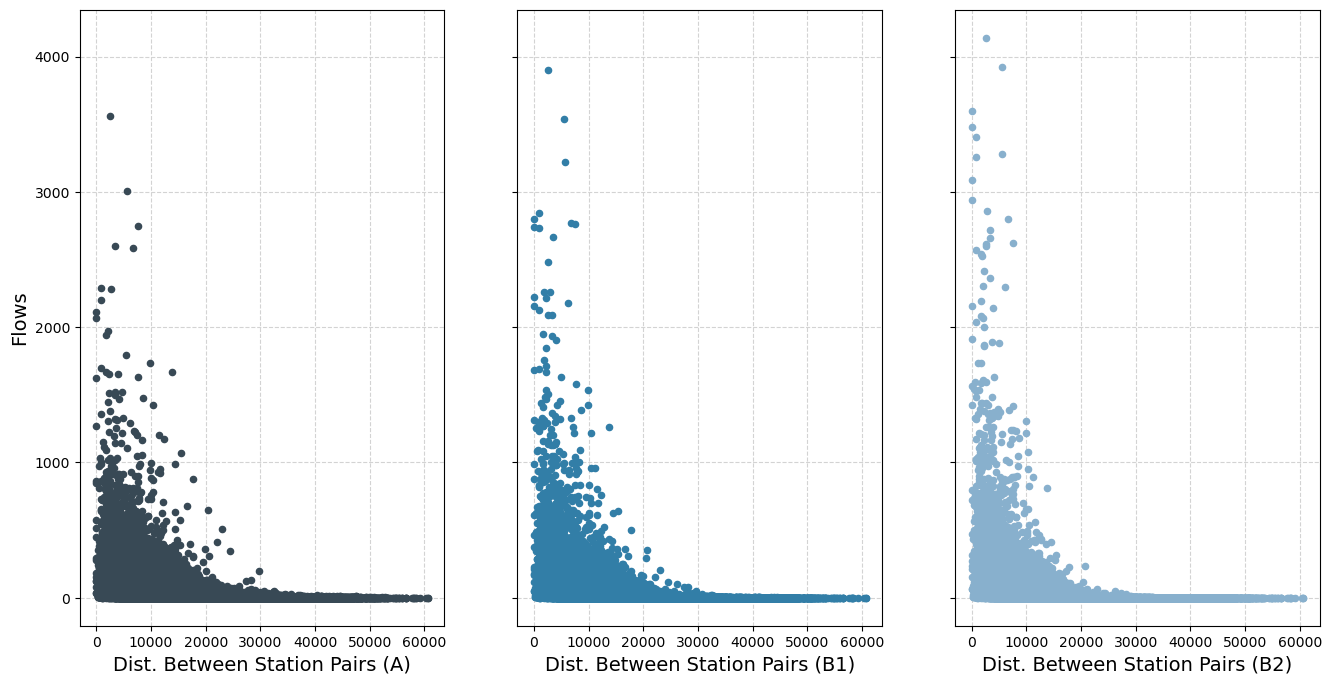

In [49]:
#Scatterplot/regression
#Basic vis
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True)

plta = flows.plot(kind='scatter', x='distance', y='flows_scenario_a', ax=axs[0], figsize=(16, 8), color='#384955', zorder=2)
plta.set_xlabel('Dist. Between Station Pairs (A)', fontsize=14)
plta.set_ylabel('Flows' ,fontsize=14)
plta.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb1 = flows.plot(kind='scatter', x='distance', y='flows_scenario_b1', ax=axs[1], figsize=(16, 8), color='#327EA7', zorder=2)
pltb1.set_xlabel('Dist. Between Station Pairs (B1)', fontsize=14)
pltb1.set_ylabel('Flows' ,fontsize=14)
pltb1.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb2 = flows.plot(kind='scatter', x='distance', y='flows_scenario_b2', ax=axs[2], figsize=(16, 8), color='#88B0CD', zorder=2)
pltb2.set_xlabel('Dist. Between Station Pairs (B2)', fontsize=14)
pltb2.set_ylabel('Flows' ,fontsize=14)
pltb2.grid(color='#d3d3d3', linestyle='--', zorder=1)

/Users/gavinrolls/anaconda3/envs/urbsim/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


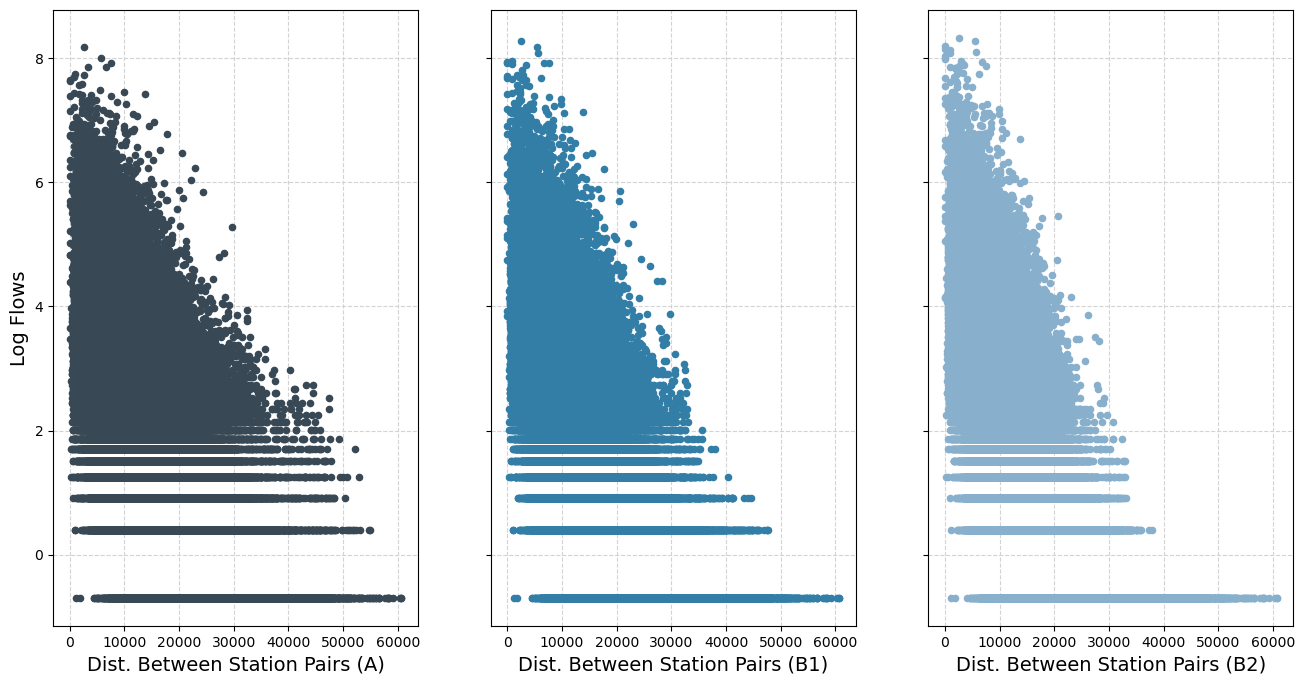

In [50]:
#Scatterplot/regression log versus distance

fig, axs = plt.subplots(1, 3, sharey=True, sharex=True)

flows['log_flows_scenario_a'] = np.log(flows['flows_scenario_a'] + .5)
flows['log_flows_scenario_b1'] = np.log(flows['flows_scenario_b1'] + .5)
flows['log_flows_scenario_b2'] = np.log(flows['flows_scenario_b2']+ .5)

flows['log_dist'] = np.log(flows['distance'])

plta = flows.plot(kind='scatter', x='distance', y='log_flows_scenario_a', ax=axs[0], figsize=(16, 8), color='#384955', zorder=2)
plta.set_xlabel('Dist. Between Station Pairs (A)', fontsize=14)
plta.set_ylabel('Log Flows' ,fontsize=14)
plta.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb1 = flows.plot(kind='scatter', x='distance', y='log_flows_scenario_b1', ax=axs[1], figsize=(16, 8), color='#327EA7', zorder=2)
pltb1.set_xlabel('Dist. Between Station Pairs (B1)', fontsize=14)
pltb1.set_ylabel('Log Flows' ,fontsize=14)
pltb1.grid(color='#d3d3d3', linestyle='--', zorder=1)

pltb2 = flows.plot(kind='scatter', x='distance', y='log_flows_scenario_b2', ax=axs[2], figsize=(16, 8), color='#88B0CD', zorder=2)
pltb2.set_xlabel('Dist. Between Station Pairs (B2)', fontsize=14)
pltb2.set_ylabel('Log Flows' ,fontsize=14)
pltb2.grid(color='#d3d3d3', linestyle='--', zorder=1)

In [51]:
#Linear Regression of each of the above figures
a_reg = smf.ols(formula='log_flows_scenario_a ~ distance', data = flows).fit()
b1_reg = smf.ols(formula='log_flows_scenario_b1 ~ distance', data = flows).fit()
b2_reg = smf.ols(formula='log_flows_scenario_b2 ~ distance', data = flows).fit()

print('Beta_1 for Scenario A: ' + str(a_reg.params[1]))
print('Beta_1 for Scenario B1: ' + str(b1_reg.params[1]))
print('Beta_1 for Scenario B2: ' + str(b2_reg.params[1]))

print(a_reg.summary())
print(b1_reg.summary())
print(b2_reg.summary())


Beta_1 for Scenario A: -0.00010649456855481164
Beta_1 for Scenario B1: -0.00012847561818171097
Beta_1 for Scenario B2: -0.00014107511373882167
                             OLS Regression Results                             
Dep. Variable:     log_flows_scenario_a   R-squared:                       0.371
Model:                              OLS   Adj. R-squared:                  0.371
Method:                   Least Squares   F-statistic:                 3.631e+04
Date:                  Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                          15:42:16   Log-Likelihood:            -1.0344e+05
No. Observations:                 61451   AIC:                         2.069e+05
Df Residuals:                     61449   BIC:                         2.069e+05
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t    

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/587890093.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Beta_1 for Scenario A: ' + str(a_reg.params[1]))
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/587890093.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Beta_1 for Scenario B1: ' + str(b1_reg.params[1]))
/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_4159/587890093.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior